<a href="https://colab.research.google.com/github/Herick-Asmani/Dermatologist-AI/blob/master/Derma_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!unzip "/content/gdrive/My Drive/Cancer_Data.zip"

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

!pip install pretrainedmodels

import pretrainedmodels

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# Data augmentation

train_transforms = transforms.Compose([transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(45),
                                       transforms.RandomAffine(45),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

validation_transforms = transforms.Compose([transforms.Resize(356),
                                            transforms.CenterCrop(299),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5, 0.5, 0.5],
                                                                 [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(356),
                                            transforms.CenterCrop(299),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5, 0.5, 0.5],
                                                                 [0.5, 0.5, 0.5])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder('./Cancer_data/train', transform=train_transforms)
validation_data = datasets.ImageFolder('./Cancer_data/valid', transform=validation_transforms)
test_data = datasets.ImageFolder('./Cancer_data/test', transform=validation_transforms)

# Using the image datasets and the tranforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size= 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 16, shuffle = True)

In [0]:
# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

In [0]:
# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(validation_data))
print('Number of test images: ', len(test_data))

Number of training images:  2000
Number of validation images:  150
Number of test images:  600


In [0]:
# Analyzing the shape of one batch
train_images, train_labels = next(iter(train_loader))
validation_images, validation_labels = next(iter(validation_loader))
test_images, test_labels = next(iter(test_loader))

print('Shape of first batch of training images: ', train_images.shape)
print('Shape of first batch of validation images: ', validation_images.shape)
print('Shape of first batch of test images: ', test_images.shape)

Shape of first batch of training images:  torch.Size([16, 3, 299, 299])
Shape of first batch of validation images:  torch.Size([16, 3, 299, 299])
Shape of first batch of test images:  torch.Size([16, 3, 299, 299])


In [0]:
len(train_loader.dataset)

2000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

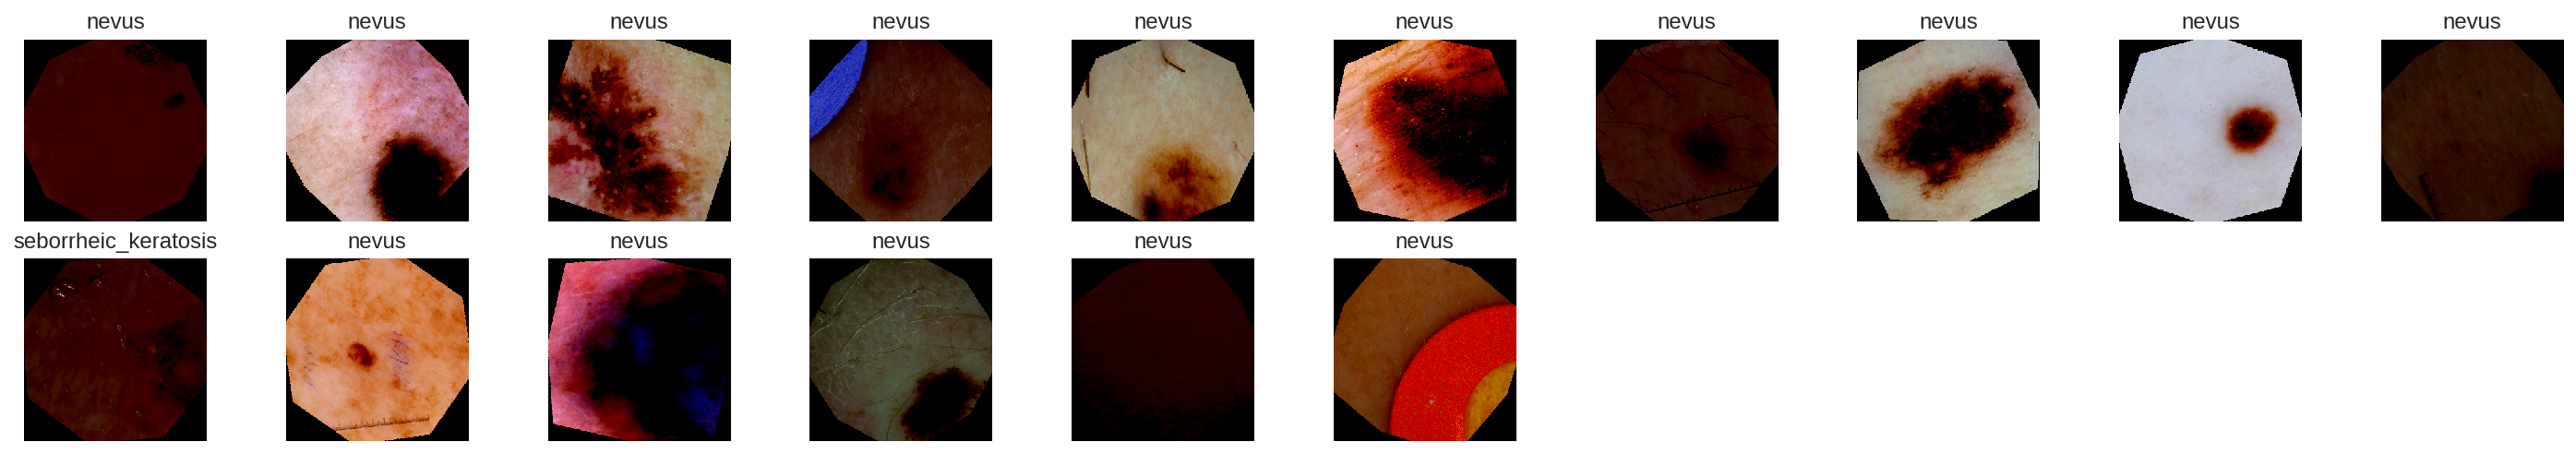

In [0]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [0]:
print(pretrainedmodels.pretrained_settings['inceptionresnetv2'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}, 'imagenet+background': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1001}}


In [0]:
model = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')
model

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [0]:
#Freeze the initial layers

for param in model.parameters():
  param.requies_grad = False
    
classifier = nn.Linear(1536, len(classes))
                   
    
model.last_linear = classifier
model

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# secify scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [0]:
# number of epochs to train the model
if train_on_gpu:
    model.cuda()
    
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in validation_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    val_accuracy = val_accuracy/len(validation_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss_min}
    
        torch.save(checkpoint, 'inceptres_model_checkpoint.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.7808 	Training Accuracy: 0.6815 	Validation Loss: 0.9586 	Validation Accuracy: 0.6067
Validation loss decreased (inf --> 0.958627).  Saving model ...
Epoch: 2 	Training Loss: 0.7290 	Training Accuracy: 0.6885 	Validation Loss: 0.8873 	Validation Accuracy: 0.5600
Validation loss decreased (0.958627 --> 0.887320).  Saving model ...
Epoch: 3 	Training Loss: 0.7201 	Training Accuracy: 0.6970 	Validation Loss: 0.8293 	Validation Accuracy: 0.5867
Validation loss decreased (0.887320 --> 0.829334).  Saving model ...
Epoch: 4 	Training Loss: 0.6987 	Training Accuracy: 0.7010 	Validation Loss: 0.7419 	Validation Accuracy: 0.6333
Validation loss decreased (0.829334 --> 0.741890).  Saving model ...
Epoch: 5 	Training Loss: 0.6849 	Training Accuracy: 0.7145 	Validation Loss: 0.7039 	Validation Accuracy: 0.7267
Validation loss decreased (0.741890 --> 0.703896).  Saving model ...
Epoch: 6 	Training Loss: 0.6732 	Training Accuracy: 0.7125 	Validation Loss: 1.1700 	Validation

In [0]:
checkpoint = torch.load("./inceptres_model_checkpoint (8).pth", map_location='cpu')

# Fine-tuning the entire model

model = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(1536, len(classes))
                   
    
model.last_linear = classifier

model.load_state_dict(checkpoint['model_state'], strict=False)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer with new learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# secify scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

#optimizer.load_state_dict(checkpoint['optimizer_state'])
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']

In [0]:
valid_loss

0.46815329233805336

In [0]:
num_epoch

43

In [0]:
# number of epochs to train the model
if train_on_gpu:
    model.cuda()
    
n_epochs = 60

valid_loss_min = valid_loss # track change in validation loss

for epoch in range(num_epoch, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    train_accuracy = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Calculate training accuracy
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in validation_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Calculate validation accuracy
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    train_accuracy = train_accuracy/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    val_accuracy = val_accuracy/len(validation_loader.dataset)
    scheduler.step(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        
        checkpoint = {"model": model,
                      "criterion": criterion,
                      "epochs": epoch,
                      "optimizer_state": optimizer.state_dict(),
                      "model_state": model.state_dict(),
                      "valid_loss_min": valid_loss_min}
    
        torch.save(checkpoint, 'inceptres_model_checkpoint.pth')
        valid_loss_min = valid_loss

Epoch: 43 	Training Loss: 0.4341 	Training Accuracy: 0.8155 	Validation Loss: 0.4658 	Validation Accuracy: 0.8267
Validation loss decreased (0.468153 --> 0.465791).  Saving model ...
Epoch: 44 	Training Loss: 0.4268 	Training Accuracy: 0.8240 	Validation Loss: 0.4936 	Validation Accuracy: 0.8067
Epoch: 45 	Training Loss: 0.4102 	Training Accuracy: 0.8290 	Validation Loss: 0.4589 	Validation Accuracy: 0.8333
Validation loss decreased (0.465791 --> 0.458920).  Saving model ...
Epoch: 46 	Training Loss: 0.4251 	Training Accuracy: 0.8145 	Validation Loss: 0.4733 	Validation Accuracy: 0.8200
Epoch: 47 	Training Loss: 0.3950 	Training Accuracy: 0.8385 	Validation Loss: 0.4944 	Validation Accuracy: 0.8333
Epoch: 48 	Training Loss: 0.4060 	Training Accuracy: 0.8215 	Validation Loss: 0.4727 	Validation Accuracy: 0.8267
Epoch: 49 	Training Loss: 0.3963 	Training Accuracy: 0.8395 	Validation Loss: 0.5151 	Validation Accuracy: 0.8067
Epoch: 50 	Training Loss: 0.4099 	Training Accuracy: 0.8295 	Val

In [0]:
checkpoint = torch.load("./inceptres_model_checkpoint.pth")

model = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained=False)
# for param in model.parameters():
#   param.requires_grad = False

    
classifier = nn.Linear(1536, len(classes))
                   
    
model.last_linear = classifier

model.load_state_dict(checkpoint['model_state'])

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# secify scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

#optimizer.load_state_dict(checkpoint['optimizer_state'])
valid_loss = checkpoint["valid_loss_min"] 
num_epoch = checkpoint['epochs']
opt = checkpoint['optimizer_state']

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

#move model to gpu
model.cuda()
model.eval()
# iterate over test data

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],
                                                         np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.622025

Test Accuracy of melanoma: 52% (61/117)
Test Accuracy of nevus: 85% (337/393)
Test Accuracy of seborrheic_keratosis: 67% (61/90)

Test Accuracy (Overall): 76% (459/600)


In [0]:
import glob 

test_dir = ["Cancer_data/test/melanoma", 
              "Cancer_data/test/nevus",
              "Cancer_data/test/seborrheic_keratosis"]

def get_images_paths(directory):
  img_paths = []
  for i in range(3):
    for file in glob.glob(directory[i]+"/*.jpg"):
      img_paths.append(file)
  return img_paths

img_paths = get_images_paths(test_dir)
print(len(img_paths))

600


In [0]:
img_paths[0]

'Cancer_data/test/melanoma/ISIC_0013411.jpg'

In [0]:
from PIL import Image

def load_image(path):
  image = Image.open(path)
  image = test_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

def get_predictions(img_paths):
  """ Is melanoma? """
  pred_task1 = [] # Is melanoma?
  pred_task2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    img = img.cuda()
    prediction = model(img)
    pred_task1.append(float(prediction.data[0][0]))
    pred_task2.append(float(prediction.data[0][2]))
  return pred_task1, pred_task2

model.cuda()
model.eval()
print("")

In [0]:
task1, task2 = get_predictions(img_paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [0]:
print("Task 1 predictions: ", len(task1))
print("first five predictions (Task 1): ", task1[:5])

print("Task 2 predictions: ", len(task2))
print("first five predictions (Task 2): ", task2[:5])

Task 1 predictions:  600
first five predictions (Task 1):  [-0.6749739050865173, 1.76010000705719, -0.11052025109529495, 0.8837434649467468, -1.0895054340362549]
Task 2 predictions:  600
first five predictions (Task 2):  [-0.6473934650421143, -5.632574081420898, -1.6902252435684204, -2.3085556030273438, -3.2649800777435303]


In [0]:
import csv
        
with open('result.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])

In [0]:
# Task wise scores

Category 1 Score: 0.810
Category 2 Score: 0.924
Category 3 Score: 0.867